In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
# Initial Setup for Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
import json, cv2, gc

Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import scipy.misc
from scipy.ndimage import rotate
from scipy.stats import bernoulli

In [4]:
from utils import *
#from preprocessing import *
import matplotlib.pyplot as plt
import scipy.misc
from scipy.ndimage import rotate
from scipy.stats import bernoulli
import cv2
from keras import backend as K
import json
import gc

In [5]:
#Dataset Path
PATH = './data/'
data_csv = '/driving_log.csv'

read the driving logs from input address, and display top 5

In [6]:
import pandas as pd
driving_log = pd.read_csv(PATH+data_csv, names = None)
print(driving_log.shape)
driving_log.head()

(8036, 7)


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


visiulization the steering dataset, and we can see there only have 8000 labeld data, and this data is only labed the center image, so we can labed the left and right images, then we can have more data for training stage. and we can see the frequent steering is between 0.25 to -0.25.

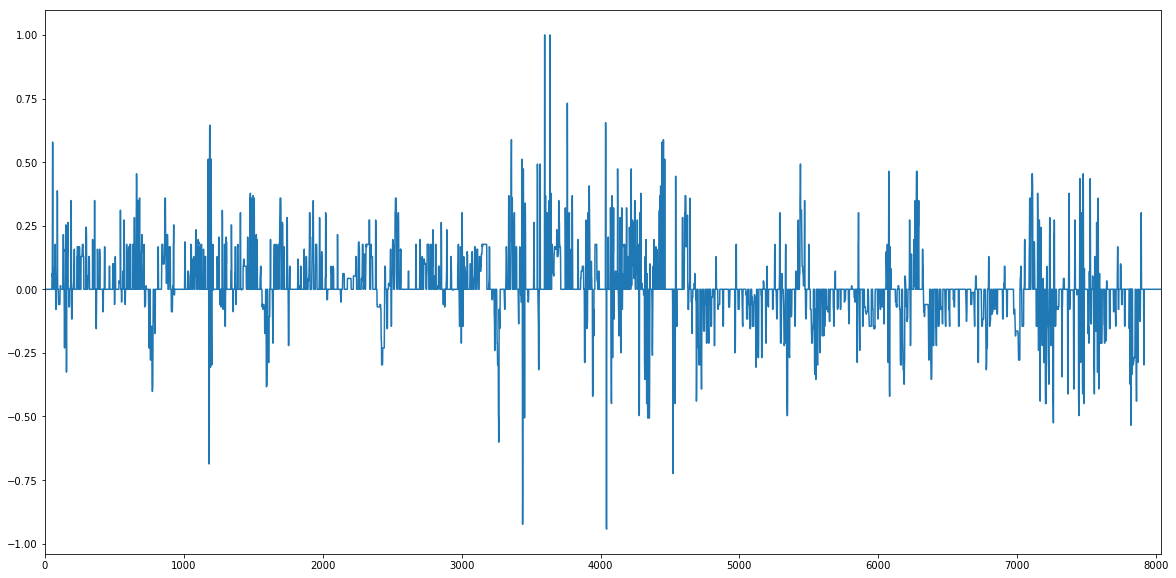

In [7]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.figure(figsize=(20,10));
driving_log['steering'].plot()

Set hyper parameters here, e.g. the start learning rate and number of training and validate samples

In [8]:
#nb_epoch = 6
number_of_samples_per_epoch = 25728
number_of_validation_samples = 6432
learning_rate = 1e-4
activation_relu = 'elu'

load some images for visiulization purpose

In [10]:
#read train & validate image from dataset
def load_image(X):
    image = plt.imread(PATH+X.strip(' '))
    return image
downsamples = 10
centerImgs = np.array([load_image(imgLoc) for imgLoc in driving_log['center'][0:downsamples]], dtype=np.float32)
leftImgs = np.array([load_image(imgLoc) for imgLoc in driving_log['left'][0:downsamples]], dtype=np.float32)
rightImgs = np.array([load_image(imgLoc) for imgLoc in driving_log['right'][0:downsamples]], dtype=np.float32) 


analyze those image and steering, we labed the y for left is Y[center] + 0.25, and right is Y[center] - 0.25

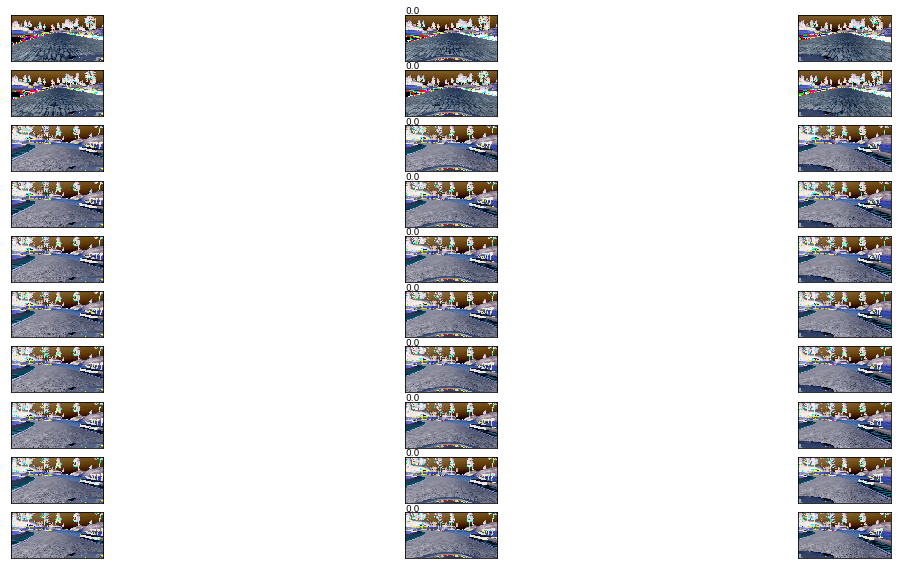

In [11]:
_, ax = plt.subplots( 10, 3, figsize=(20, 10))
col, row = 0, 0
print(  )
for i in range(downsamples):
    centerImg =  centerImgs[i]
    leftImg = leftImgs[i]
    rightImg = rightImgs[i]
    ax[i, 0].imshow(leftImg)
    ax[i, 0].get_xaxis().set_ticks([])
    ax[i, 0].get_yaxis().set_ticks([])
    ax[i, 1].imshow(centerImg)
    ax[i, 1].get_xaxis().set_ticks([])
    ax[i, 1].get_yaxis().set_ticks([])
    ax[i, 1].text(3, -5, driving_log['steering'][i], fontsize=9)
    ax[i, 2].imshow(rightImg)
    ax[i, 2].get_xaxis().set_ticks([])
    ax[i, 2].get_yaxis().set_ticks([])

plt.show()

build the nets, using lambda to normalize the data.

In [12]:
def Nets_Build():
    #NVIDIA SELF DRIVING CAR MODEL USING HERE(modiefy)
    model = Sequential()
    #model.add(Cropping2D(cropping=((100,40), (0,0)), input_shape=(160,320,3)))
    #Normalize
    model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(160, 320, 3)))
    #BatchNormalization here
    model.add(BatchNormalization(epsilon=0.001, mode=2, axis=1, input_shape=(160, 320, 3)))
    #Fist convolution the images
    model.add(Convolution2D(3, 1, 1,border_mode='same', subsample=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    #Then we crop the filter maps 
    model.add(Cropping2D(cropping=((25,5),(0,0))))#75,25, 50,10
    
    
    # start convolution layers here
    model.add(Convolution2D(36, 3, 3,border_mode='same', subsample=(2, 2)))
    model.add(Activation(activation_relu))
    #model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Convolution2D(48, 3, 3,border_mode='same', subsample=(2, 2)))
    model.add(Activation(activation_relu))
    #model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(48, 3, 3,border_mode='same', subsample=(2, 2)))
    model.add(Activation(activation_relu))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3,border_mode='same', subsample=(1, 1)))
    model.add(Activation(activation_relu))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3,border_mode='same', subsample=(1, 1)))
    model.add(Activation(activation_relu))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    # use fcn to reduce the parameters, so replace the fc layers
    model.add(Convolution2D(96, 3, 3,border_mode='same', subsample=(1, 1)))
    model.add(Activation(activation_relu))
    
    model.add(Convolution2D(96, 3, 3,border_mode='same', subsample=(1, 1)))
    model.add(Activation(activation_relu))
    
    model.add(Convolution2D(50, 1, 1,border_mode='same', subsample=(1, 1)))
    model.add(Activation(activation_relu))
    
    model.add(Convolution2D(10, 1, 1,border_mode='same', subsample=(1, 1)))
    model.add(Activation(activation_relu))
    model.add(Flatten())

    # Next, five fully connected layers
    #model.add(Dense(500))
    #model.add(Activation(activation_relu))
    #model.add(Dropout(0.5))
    #model.add(Dense(50))
    #model.add(Convolution2D(200, 1, 1,border_mode='same', subsample=(1, 1)))
    #model.add(Activation(activation_relu))
    #model.add(Flatten())
    #model.add(Dropout(0.5))
    #model.add(Dense(50))
    #model.add(Activation(activation_relu))
    #model.add(Dropout(0.5))    
    model.add(Dense(10))
    model.add(Activation(activation_relu))
    
    model.add(Dense(1))
    model = opt(model)
    return model

In [13]:
def opt(model, learning_rate = learning_rate):
    model.summary()
    model.compile(optimizer=Adam(learning_rate), loss="mse", )
    return model

using batch generate tech here,  to generate data for training rather than storing the training data in memory, and the data augmentation used here please see the util.py

In [14]:
def train(model):
    x,y = read_csv()
    x,y = datashuffle(x,y)
    #X_Tleft, X_Tright, X_Tcenter,Y_T, X_Vleft, X_Vright, X_Vcenter, Y_V = trainval_split(x, y)
    X_train, X_val, Y_train, Y_val = trainval_split(x, y)
    X_left  = X_train['left'].as_matrix()
    X_right = X_train['right'].as_matrix()
    X_center = X_train['center'].as_matrix()
    Y = Y_train.as_matrix()
    #X_train, Y_train = load_data(X_train, Y_train)
    #X_train, Y_train = data_augmentation(X_train, Y_train)
    #X_val, Y_val = load_data(X_val, Y_val)
    #X_val, Y_val = data_augmentation(X_val, Y_val)
    #print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
    train_gen = generate_train_batch(X_center, X_left, X_right,Y, batch_size = 64)
    #validation_gen = generate_train_batchV1(X_val,Y_val, batch_size = 64)
    X_left  = X_val['left'].as_matrix()
    X_right = X_val['right'].as_matrix()
    X_center = X_val['center'].as_matrix()
    Y = Y_val.as_matrix()
    validation_gen = generate_train_batch(X_center, X_left, X_right,Y, batch_size = 64)
    history = model.fit_generator(train_gen,
                              samples_per_epoch=number_of_samples_per_epoch,
                              nb_epoch=5,
                              validation_data=validation_gen,
                              nb_val_samples=number_of_validation_samples,
verbose=1)
    return model

In [18]:
def train_model():
    model = Nets_Build()
    model = train(model)
    #save_model(model)
    json_string = model.to_json()
    model_json = 'model.json'
    model_weights = 'model.h5'
    try:
        os.remove(model_json)
        os.remove(model_weights)
    except OSError:
        pass

    with open(model_json, 'w') as jfile:
        json.dump(json_string, jfile)
    model.save_weights(model_weights)
    return model

In [19]:
model = train_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 160, 320, 3)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 160, 320, 3)   640         lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 80, 160, 3)    12          batchnormalization_2[0][0]       
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 79, 159, 3)    0           convolution2d_11[0][0]           
___________________________________________________________________________________________